In [1]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [6]:
training_inputs = np.load('training_inputs.npy')
training_ground_truth = np.load('training_ground_truth.npy')

In [12]:
seed = 0
alpha = 10
sigma = 10
#Define some additional transormations
def elastic_transform(image):
    #alpha, sigma, random_state must be passed as global variables
    random_state = np.random.RandomState(seed)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    dy = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    
    x,y = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
    indices = np.reshape(y+dy,(-1,1)), np.reshape(x+dx,(-1,1))
    
    transformed_image = map_coordinates(image,indices,order=1,mode='reflect')
    return transformed_image.reshape(shape)

def random_noise(image):
    #add random_noise to the images
    #seed must be passed as a global variable
    random_state = np.random.RandomState(seed)
    noise_mag = random_state.normal()
    noise = tf.random.normal(shape = image.shape,
                             mean=0.0,
                             stddev=noise_mag
                            )
    transformed_image = image+noise
    return transformed_image

def random_crop(image):
    #randomly crops a 512 by 384 section
    #random_state is determined by a global variable
    random_state = np.random.RandomState(seed)
    image_shape = image.shape
    lower_left_x = random_state.choice(image_shape[1] // 4)
    upper_right_x = lower_left_x + 512
    lower_left_y = random_state.choice(image_shape[0] // 4)
    upper_right_y = lower_left_y + 384
    transformed_image = image[lower_lefty:upper_right_y,lower_left_x:upper_right_y]
    return transformed_image
    

In [15]:
def additional_image_transformations(image):
    #randomly add noise and a deformation
    #always crop
    random_state = np.random.RandomState(seed)
    if random_state.choice(2) == 1:
        transformed_image = random_noise(image)
    if random_state.choice(2) == 1:
        transformed_image = elastic_transform(transformed_image)
    transformed_image = random_crop(transformed_image)
    return transformed_image

def additional_mask_transformations(image):
    #randomly add a deformation
    #always crop
    random_state = np.random.RandomState(seed)
    if random_state.choice(2) == 1:
        pass
    if random_state.choice(2) == 1:
        transformed_image = elastic_transform(image)
    transformed_image = random_crop(transformed_image)
    return transformed_image

In [16]:
# we create two instances with the same arguments
mask_gen_args = {'rotation_range':90,
                 'width_shift_range':0.35,
                 'height_shift_range':0.35,
                 'zoom_range':0.5,
                 'fill_mode':'reflect',
                 'horizontal_flip':True,
                 'vertical_flip':True,
                 'preprocessing_function':additional_mask_transformations
                }

image_gen_args = mask_gen_args.copy()
image_gen_args.update({'featurewise_center':True,
                       'featurewise_std_normalization':True,
                       'brightness_range':[-0.2,0.2]
                      })
image_gen_args['preprocessing_function'] = additional_image_transformations

In [19]:
#Instantiate Data Generators
image_datagen = ImageDataGenerator(**image_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

#Find means and variances for some transforms
image_datagen.fit(training_inputs)

In [23]:
mask = training_ground_truth[0,:,:,:]
image = training_inputs[0,:,:,:]
seed=1292
transformed_mask = mask_datagen.random_transform(mask,seed=seed)
transformed_image = image_datagen.random_transform(image,seed=seed)

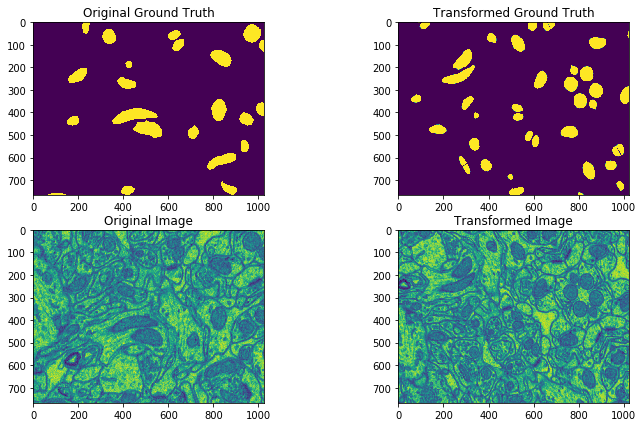

In [24]:
fig = plt.figure(figsize=[12,7])
ax1 = plt.subplot(2,2,1)
ax1.imshow(mask[:,:,0])
ax1.set_title('Original Ground Truth')
ax2 = plt.subplot(2,2,2)
ax2.imshow(transformed_mask[:,:,0])
ax2.set_title('Transformed Ground Truth')
ax3 = plt.subplot(2,2,3)
ax3.imshow(image[:,:,0])
ax3.set_title('Original Image')
ax4 = plt.subplot(2,2,4)
ax4.imshow(transformed_image[:,:,0])
ax4.set_title('Transformed Image')
plt.show()

In [25]:
image_generator = image_datagen.flow(
    training_inputs,
    seed=seed)
mask_generator = mask_datagen.flow(
    training_ground_truth,
    seed=seed)
                 
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [ ]:
#This next bit needs to be combined with a neural net model
model.fit_generator(
    train_generator,
    steps_per_epoch=2000,
    epochs=50)